In [1]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
# !pip install torchtext

     |████████████████████████████████| 4.5 MB 4.4 MB/s eta 0:00:01


In [2]:
import json
from pandas.io.json import json_normalize

file = '../dataset/train_rand_split.jsonl'

def load_data(file):

    lines = []
    with open(file, 'rb') as json_file:
        for json_line in json_file:
            lines.append(json.loads(json_line))
        data = json_normalize(lines)
        data.columns = data.columns.map(lambda x: x.split(".")[-1])
    return data

train = load_data(file)
dev = load_data('../dataset/dev_rand_split.jsonl')
train.head()

<ipython-input-2-5cef278bafa6>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  data = json_normalize(lines)


,answerKey,id,question_concept,choices,stem
0,A,075e483d21c29a511267ef62bedc0461,punishing,"[{'label': 'A', 'text': 'ignore'}, {'label': '...",The sanctions against the school were a punish...
1,B,61fe6e879ff18686d7552425a36344c8,people,"[{'label': 'A', 'text': 'race track'}, {'label...",Sammy wanted to go to where the people were. ...
2,A,4c1cb0e95b99f72d55c068ba0255c54d,choker,"[{'label': 'A', 'text': 'jewelry store'}, {'la...",To locate a choker not located in a jewelry bo...
3,D,02e821a3e53cb320790950aab4489e85,highway,"[{'label': 'A', 'text': 'united states'}, {'la...",Google Maps and other highway and street GPS s...
4,C,23505889b94e880c3e89cff4ba119860,fox,"[{'label': 'A', 'text': 'pretty flowers.'}, {'...","The fox walked from the city into the forest, ..."


In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

lab_order = {"A": 0, "B":1, "C":2, "D":3, "E":4}

class InputExample(object):
    """A single multiple choice question."""
    # This class is adapted from https://github.com/jonathanherzig/commonsenseqa/blob/master/bert/run_commonsense_qa.py

    def __init__(
            self,
            qid,
            question,
            answer,
            label):
        """Construct an instance."""
        self.qid = qid
        self.question = question  # e.g., 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?'
        self.answer = answer      # e.g., "ignore" if choice label is A 
        self.label = label        # e.g., If correct answer, 1. Otherwise 0. 
        
    def __str__(self):
        return "QUESTION: {}\nANSWER  : {}\nLABEL   : {}".format(self.question, self.answer, self.label)
    
    
def create_example(row, choice_num):
    qid = row.id
    
    # Question: Just take it from stem 
    question = row.stem
    
    # Answer choice 
    label = int(row["answerKey"] == choice_num)  # If the answer key is equal to the answer choice number, mark 1 
    answer = row["choices"][lab_order[choice_num]]["text"]         # actual ans text 
    
    return InputExample(qid, question, answer, label) 
    
    
def process_examples(data):
    examples = []
    labels = []
    questions = []
    anscands = []
    
    
    for index, row in data.iterrows(): 
        for letter in lab_order.keys():
            example = create_example(row, letter)
            examples.append(example)
            
            questions.append(example.question)
            anscands.append(example.answer)
            labels.append(example.label)
        
    encoded_example = tokenizer(questions, anscands, padding=True, truncation=True, return_tensors='tf')
            
    return examples, encoded_example, labels


In [5]:
dev_eg, dev_encoded_eg, dev_labs = process_examples(dev)
train_eg, train_encoded_eg, train_labs = process_examples(train)

In [6]:
print(train_eg[0].question)

The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?


In [7]:
print(train_eg[0])

QUESTION: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
ANSWER  : ignore
LABEL   : 1


In [12]:
print(tokenizer.convert_ids_to_tokens(train_encoded_eg["input_ids"][0]))

['[CLS]', 'The', 'sanctions', 'against', 'the', 'school', 'were', 'a', 'punish', '##ing', 'blow', ',', 'and', 'they', 'seemed', 'to', 'what', 'the', 'efforts', 'the', 'school', 'had', 'made', 'to', 'change', '?', '[SEP]', 'ignore', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
class mymodel(tf.keras.Model):
    def __init(self,
              vocabulary_size,
              embedding_dimensions=768,   # default bert
              dropout_rate=0.1,
               model_output_classes=2,
               name="qa_classification_model"
              )
    super(mymodel, self).__init__(name=name)
    
    self.embedding = layers.Embedding(vocabulary_size,
                                     embedding_dimensions)
    
    # These are the layers that come after Bert.
    self.dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
    
    self.dense = tf.keras.layers.Dropout(rate=dropout_rate)(dense)

    if model_output_classes == 2:
        self.last_dense = tf.keras.layers.Dense(units=1,
                                       activation="sigmoid")
    else:
        self.last_dense = tf.keras.layers.Dense(units=model_output_classes,
                                       activation="softmax")
        

In [ ]:
# Define some params
VOCAB_LENGTH = 100
EMB_DIM = 768

In [ ]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                       embedding_dimensions=EMB_DIM)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, 
                    use_vocab=False, 
                    batch_first=True, 
                    dtype=torch.float)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   lower=False, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('label', label_field), 
          ('title', text_field), 
          ('text', text_field), 
          ('titletext', text_field)]

# # TabularDataset

# train, valid, test = TabularDataset.splits(
#     path=source_folder, train='train.csv', validation='valid.csv',                                       
#     test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)



/home/haeranglee_berkeley_edu/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


NameError: name 'source_folder' is not defined

# Analytics Vidhya tutorial

https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
# device = torch.device("cuda")

In [14]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
train_text, temp_text, train_labels, temp_labels = \
    train_test_split(df['text'], df['label'], 
    random_state=2018, 
    test_size=0.3, 
    stratify=df['label'])


val_text, test_text, val_labels, test_labels = \
    train_test_split(temp_text, temp_labels, 
    random_state=2018, 
    test_size=0.5, 
    stratify=temp_labels)

In [17]:
type(val_text)

pandas.core.series.Series

In [18]:
val_text.size

836

In [19]:
val_labels.size

836

In [21]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Questions
1. Find out what automodel does and how it's different from other models. Also find out what tokenizer fast is. 

2. What is batch_encode_plus and how is it different from just encode

3. Using the max length will create too many zeros. But if I don't, I lose the data. What's the right number

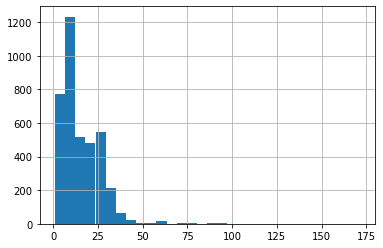

In [22]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [25]:
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews', 
          split = (tfds.Split.TRAIN, tfds.Split.TEST),
          as_supervised=True,
          with_info=True)
print('info', ds_info)


INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imdb_reviews/plain_text/1.0.0
INFO:absl:Load dataset info from /tmp/tmp14hzevh0tfds
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset imdb_reviews (/home/haeranglee_berkeley_edu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)


INFO:absl:Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz into /home/haeranglee_berkeley_edu/tensorflow_datasets/downloads/ai.stanfor.edu_amaas_sentime_aclImdb_v1PaujRp-TxjBWz59jHXsMDm5WiexbxzaFQkEnXc3Tvo8.tar.gz.tmp.a8a4cfcbda9c41f299672ac5d4c3c283...
INFO:absl:Generating split train


Shuffling and writing examples to /home/haeranglee_berkeley_edu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSFZN95/imdb_reviews-train.tfrecord


INFO:absl:Done writing /home/haeranglee_berkeley_edu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSFZN95/imdb_reviews-train.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split test


Shuffling and writing examples to /home/haeranglee_berkeley_edu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSFZN95/imdb_reviews-test.tfrecord


INFO:absl:Done writing /home/haeranglee_berkeley_edu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSFZN95/imdb_reviews-test.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split unsupervised


Shuffling and writing examples to /home/haeranglee_berkeley_edu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSFZN95/imdb_reviews-unsupervised.tfrecord


INFO:absl:Done writing /home/haeranglee_berkeley_edu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSFZN95/imdb_reviews-unsupervised.tfrecord. Shard lengths: [50000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split (Split('train'), Split('test')), from /home/haeranglee_berkeley_edu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Dataset imdb_reviews downloaded and prepared to /home/haeranglee_berkeley_edu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
info tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  

In [26]:
for review, label in tfds.as_numpy(ds_train.take(5)):
    print('review', review.decode()[0:50], label)


review This was an absolutely terrible movie. Don't be lu 0
review I have been known to fall asleep during films, but 0
review Mann photographs the Alberta Rocky Mountains in a  0
review This is the kind of film for a snowy Sunday aftern 1
review As others have mentioned, all the women that go nu 1


The positive sentiment is represented by 1 and the negative sentiment is represented by 0.



In [31]:
import tensorflow as tf

In [32]:
# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
    }, label

def encode_examples(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset
    # from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    
    if (limit > 0):
        ds = ds.take(limit)

    for review, label in tfds.as_numpy(ds):
        bert_input = tokenizer(review.decode())

        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
        
    return tf.data.Dataset.from_tensor_slices(
        (input_ids_list, 
         attention_mask_list, 
         token_type_ids_list, 
         label_list)
    ).map(map_example_to_dict)


In [ ]:
# train dataset
ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(batch_size)
# test dataset
ds_test_encoded = encode_examples(ds_test).batch(batch_size)
